In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Session1
#데이터 불러오기
#Annotation에 있는 파일 이용
import pandas as pd
data = pd.read_csv('/kaggle/input/annotation1f1m2f2m10f/annotation(F M).CSV', encoding='cp949')
data

,Segment ID,Total Evaluation,Unnamed: 2,Unnamed: 3,Script
0,Sess01_script02_F008,happy,4.5,3.6,음 내 꿈은 오빠한테 시집가는거.
1,Sess01_script02_F011,neutral;happy,4.2,3.6,어 맛있겠다.
2,Sess01_script02_F022,happy,4.5,4.0,l/ 아 오빠 너무 웃겨.
3,Sess01_script02_F023,happy,4.5,3.7,b/ 그러니깐 젓가락 100개란 게 우리들 만난 지 100일 되는 날이라서 준비했다...
4,Sess01_script02_F028,happy,4.5,3.7,대신 같이 살아야겠어.
...,...,...,...,...,...
239,Sess10_impro04_F050,happy,4.4,3.6,하여간 내가 참.
240,Sess10_impro04_F051,happy,4.5,3.8,b/ 알겠어.
241,Sess10_impro04_F052,happy,4.4,3.5,어.
242,Sess10_impro04_F053,happy,4.5,3.6,o/ 내가 하여간 내가 저 남자때문에 산다니깐. 여보.


In [4]:
#Script 추출
data_script = data.iloc[:,[4]]
data_script

,Script
0,음 내 꿈은 오빠한테 시집가는거.
1,어 맛있겠다.
2,l/ 아 오빠 너무 웃겨.
3,b/ 그러니깐 젓가락 100개란 게 우리들 만난 지 100일 되는 날이라서 준비했다...
4,대신 같이 살아야겠어.
...,...
239,하여간 내가 참.
240,b/ 알겠어.
241,어.
242,o/ 내가 하여간 내가 저 남자때문에 산다니깐. 여보.


In [5]:
def basic_eda(data, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(data.shape[1]))
    print('Info : There are {} rows in the dataset'.format(data.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_data = pd.DataFrame(data.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_data = dtypes_data[dtypes_data['dtype']=='object']
    num_data = dtypes_data[dtypes_data['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_data)))
    print('Info : There are {} numerical columns'.format(len(dtypes_data)-len(cat_data)))
    
    if list_elements_limit >= len(cat_data):
        print("Categorical columns : ", list(cat_data['column_name']))
    else:
        print("Categorical columns : ", list(cat_data['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_data):
        print("Numerical columns : ", list(num_data['column_name']))
    else:
        print("Numerical columns : ", list(num_data['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_data.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_data_num = data[list(num_data['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_data_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_data_cat = data[list(cat_data['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_data_cat.head(row_limit))
    
    return

In [6]:
basic_eda(data)

Info : There are 5 columns in the dataset
Info : There are 244 rows in the dataset

Data type information of different columns
Info : There are 3 categorical columns
Info : There are 2 numerical columns
Categorical columns :  ['Segment ID', 'Total Evaluation', 'Script']
Numerical columns :  ['Unnamed: 2', 'Unnamed: 3']


,column_name,dtype
0,Segment ID,object
1,Total Evaluation,object
2,Unnamed: 2,float64
3,Unnamed: 3,float64
4,Script,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,Unnamed: 2,244.0,4.261885,0.398121,3.0,4.0,4.3,4.500,5.0
1,Unnamed: 3,244.0,3.721311,0.515238,2.5,3.4,3.6,3.925,5.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Segment ID,244,244,Sess01_script02_F008,1
1,Total Evaluation,244,4,happy,214
2,Script,244,238,어.,4


In [7]:
# Quickly check for mising values
total = data.isnull().sum()
total

Segment ID          0
Total Evaluation    0
Unnamed: 2          0
Unnamed: 3          0
Script              0
dtype: int64

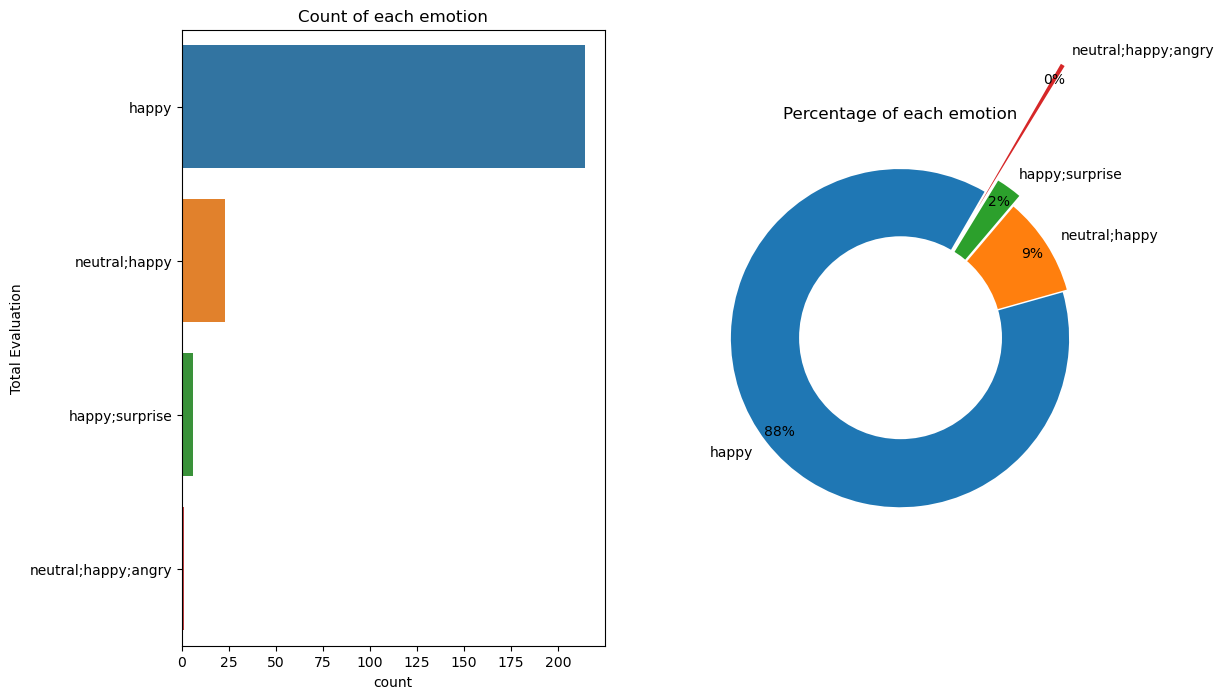

In [8]:
#Distribution of sentiments in the data
col = 'Total Evaluation'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(data[col].dropna().value_counts()))/sum(list(data[col].dropna().value_counts())))[::-1])[:10]
labels = list(data[col].dropna().unique())[:10]
sizes = data[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = data, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [9]:
data['char_length'] = data['Script'].apply(lambda x : len(x))
data['token_length'] = data['Script'].apply(lambda x : len(x.split(" ")))

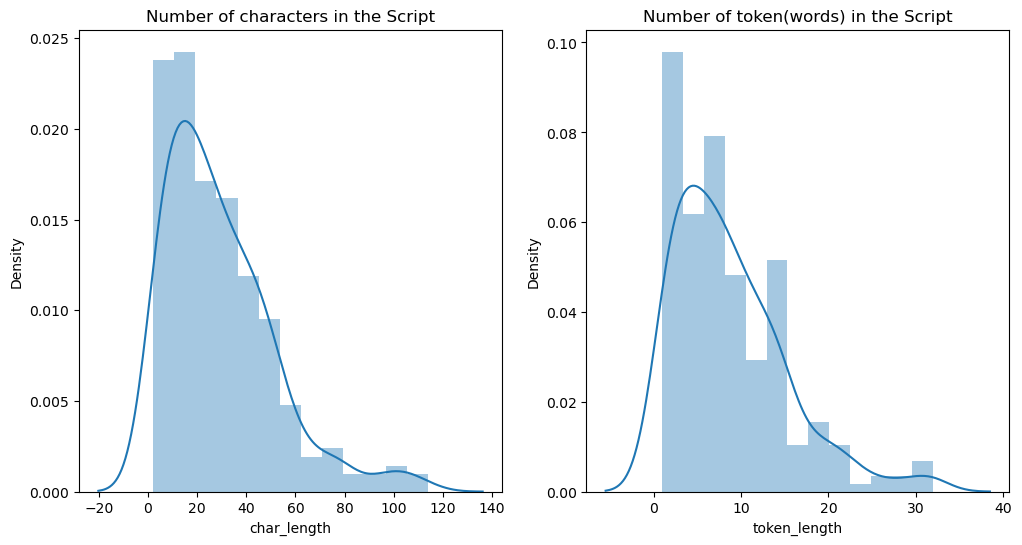

In [10]:
#Distribution of character length and token length overall

fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(data['char_length'], ax=ax1)
sns.distplot(data['token_length'], ax=ax2)
ax1.set_title('Number of characters in the Script')
ax2.set_title('Number of token(words) in the Script')
plt.show()

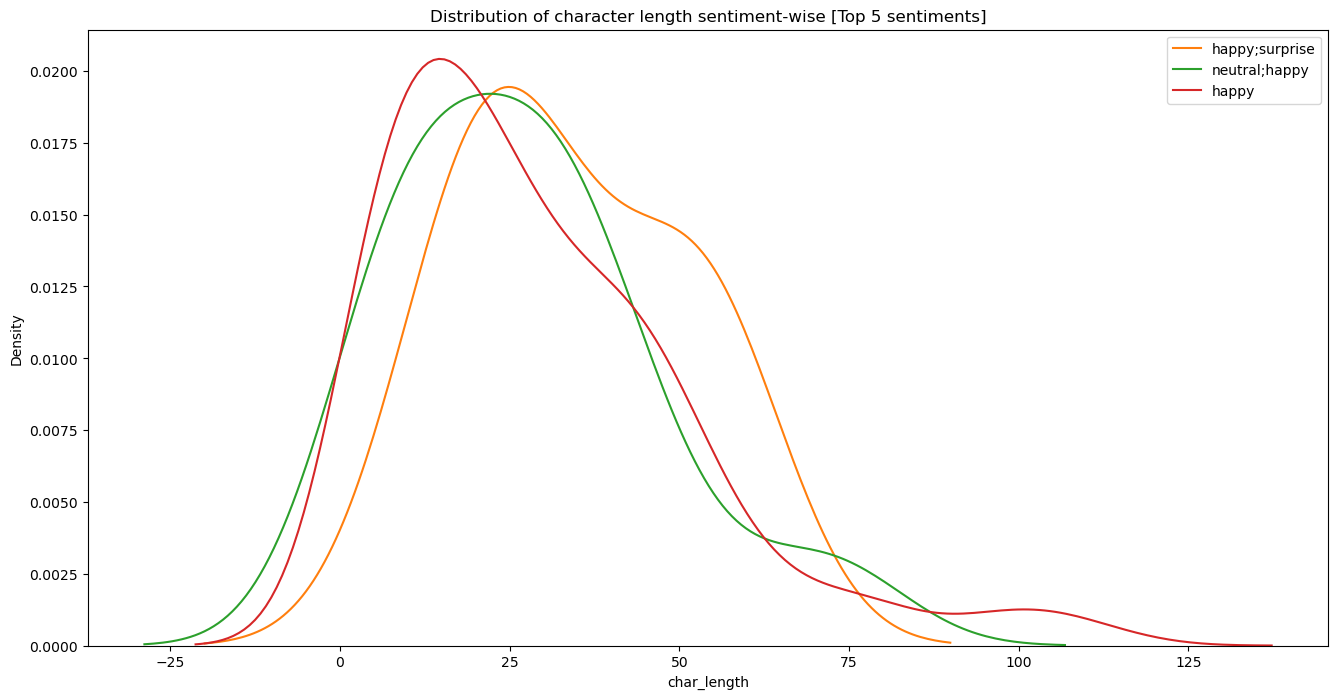

In [11]:
#Distribution of character length emotion-wise [Top 5 emotions]
fig, ax = plt.subplots(figsize=(16,8))
for emotion in data['Total Evaluation'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(data[data['Total Evaluation']== emotion]['char_length'],ax=ax, label=emotion)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 5 sentiments]")
plt.show()

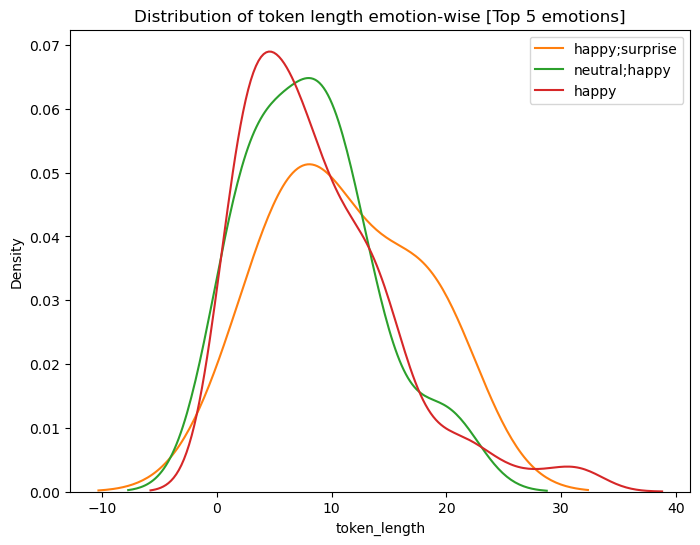

In [12]:
##Distribution of token length emotion-wise [Top 5 emotions]
fig, ax = plt.subplots(figsize=(8,6))
for emotion in data['Total Evaluation'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(data[data['Total Evaluation']==emotion]['token_length'],ax=ax, label=emotion)
ax.legend()
ax.set_title("Distribution of token length emotion-wise [Top 5 emotions]")
plt.show()

In [13]:
#most common character and token length
avg_df = data.groupby('Total Evaluation').agg({'char_length':'mean', 'token_length':'mean'})

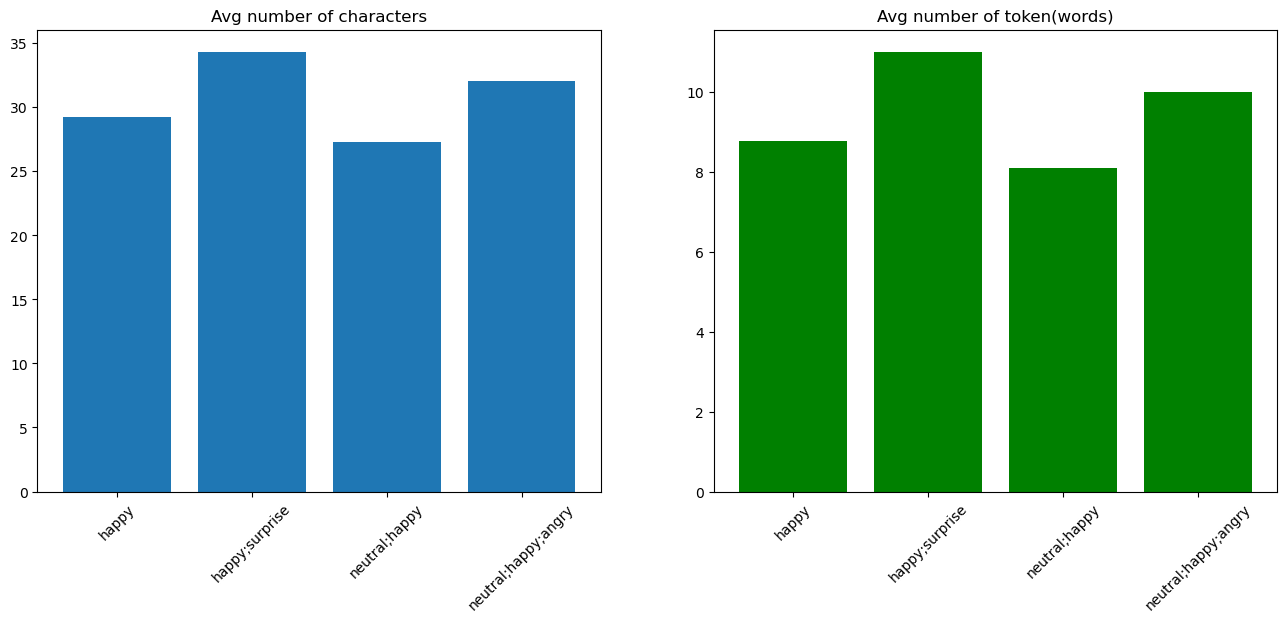

In [14]:

fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

In [19]:
!pip install inflect
!pip install contractions
# !pip install bs4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.7 MB/s eta 0:00:00


In [20]:
# Data preparation and text-preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
nltk.download('popular')
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk

In [21]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 44.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 29.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
from konlpy.tag import Okt
from konlpy.utils import pprint

In [23]:
#print the number of duplicated values 
data.duplicated().sum()

0

In [24]:
#removing duplicated values
index = data[data.duplicated() == True].index
data.drop(index, axis = 0, inplace = True)
data.reset_index(inplace=True, drop = True)

In [25]:
pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 10.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [56]:
result = []
with open('/kaggle/input/stopword2/stopwords.txt') as file:
    stop_words = file.read()
stop_words

'어머 아유 얘 쟤 저거 아이씨 아이 근데 저거 뭐 수도 있지 그게 대수인가 예스 오케바리다잉 어이고 아싸 이거 야씨 어떡하냐 어떡하 가만있어 이걸 이게 뭐 이씨 봐 알았지 좀 야 뭐야 진짜야 진 아씨 뭐라고 씨 나도 뭐 제발 대신 마침 너무 정말 난 아휴 으이그 나는 진짜지 내가 돼 음 저 아 휴 아이구 아이쿠 아이고 어 나 그지 굳이 무슨 뭘 자꾸 아니 아이 어허 아니구 탁 정말로 어디서 대순가 우아 이잉 두고봐라 에휴 하여간 아주 그니까 알겠어 저래 주책 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 뭐가 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 죽겠네 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였

In [57]:
data_script.iloc[:,0]

0                                   꿈은 오빠한테 시집가는거 .
1                                            맛있겠다 .
2                                        l/ 오빠 웃겨 .
3      b/ 그러니깐 젓가락 100개란 만난 100일 날이라서 준비했다는 거야 ? l/
4                                        대신 살아야겠어 .
                           ...                     
239                                           하여간 .
240                                        b/ 알겠어 .
241                                               .
242                           o/ 하여간 남자때문에 산다니깐 . .
243                                           사랑해 .
Name: Script, Length: 244, dtype: object

In [58]:
print(stop_words.split(" "), end = '')

['어머', '아유', '얘', '쟤', '저거', '아이씨', '아이', '근데', '저거', '뭐', '수도', '있지', '그게', '대수인가', '예스', '오케바리다잉', '어이고', '아싸', '이거', '야씨', '어떡하냐', '어떡하', '가만있어', '이걸', '이게', '뭐', '이씨', '봐', '알았지', '좀', '야', '뭐야', '진짜야', '진', '아씨', '뭐라고', '씨', '나도', '뭐', '제발', '대신', '마침', '너무', '정말', '난', '아휴', '으이그', '나는', '진짜지', '내가', '돼', '음', '저', '아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '그지', '굳이', '무슨', '뭘', '자꾸', '아니', '아이', '어허', '아니구', '탁', '정말로', '어디서', '대순가', '우아', '이잉', '두고봐라', '에휴', '하여간', '아주', '그니까', '알겠어', '저래', '주책', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를', '들면', '예를', '들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수', '없다', '해서는', '안된다', '뿐만', '아니라', '만이', '아니다', '만은', '아니다', '막론하고', '관계없이', '그치지', '않다', '그러나', '뭐가', '그런데', '하지만', '든간에', '논하지', '않다', '따지지', '않다', '설사', '비록', '더라도', '아니면', '만', '못하다', '하는', '편이', '낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '죽겠네', '제외

In [59]:
#불용어 제거 함수
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    result = []
    for word in word_tokens: 
        if word not in stop_words: 
            result.append(word)
    text_cleaned = " ".join(result)
    #print('불용어 제거 전 :',word_tokens) 
    #print('불용어 제거 후 :',result)
    return text_cleaned


In [60]:
#불용어 제거 결과
for i in range(len(data_script)):
    data_script.iloc[i, 0] = remove_stopwords(data_script.iloc[i, 0])
data_script

,Script
0,꿈은 오빠한테 시집가는거 .
1,맛있겠다 .
2,l/ 오빠 웃겨 .
3,b/ 그러니깐 젓가락 100개란 만난 100일 날이라서 준비했다는 거야 ? l/
4,살아야겠어 .
...,...
239,.
240,b/ .
241,.
242,o/ 남자때문에 산다니깐 . .


In [61]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [62]:
script = []
okt = Okt()
for row in range(len(data_script)):
    txt = data_script.iloc[row, 0]
    script.append(txt)
    print(okt.morphs(txt, norm=True, stem=True), end = ' ')

['꿈', '은', '오빠', '한테', '시집가다', '.'] ['맛있다', '.'] ['l', '/', '오빠', '웃기다', '.'] ['b', '/', '그렇다', '젓가락', '100', '개다', '만난', '100일', '날', '이라서', '준비', '하다', '거야', '?', 'l', '/'] ['살다', '.'] ['.', '오빠', '는', '젓가락', '을', '주다', '좋다', '줄', '게', '.'] ['o', '/', 'N', '/', 's', '/', '오빠', '어떻다', '해', '어떻다', '해', '.'] ['o', '/', 'N', '/', '꼬집다', '줄', '게', '.'] ['o', '/', 'N', '/', '제대로', '꼬부', '꼬집다', '꿈', '인지', '아니다', '.'] ['o', '/', 'N', '/', '사랑', '하다', '오빠', '.', '잊다', '.', '잊다', '.', '?', '?', '구두', '를', '새롭다', '사다', '되다', '.'] ['o', '/', 'N', '/', '.', '걱정', '하다', '.', '입', '이', '무겁다', '신상', '구두', '(', ')'] ['o', '/', 'N', '/', '걱정', '.', '오빠', '동생', '이야', '.', '친', '동생', '.', '?', '믿다', '?'] ['l', '/', '오빠', '아', '아앙', '오빠', '자다', '알다', '.'] ['o', '/', 'N', '/', '오빠', '앙', '친구', '은지', '랑', '소개팅', '하고', '싶다', '그렇다', '?', '주선', '해보다', '?'] ['o', '/', 'N', '/', '지금', '지금', '전화', '걸다', '친구', '들', '많다', '.'] ['?', '?', '?', '?', 'o', '/', '오빠', '오빠', '짱', '이야', '최고', '야', '.', 'o', '/', '나', '한텐

In [72]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {".":"","u": "", "o":"", "n":"", "+":"", "o/":"", "N":"", "l/":"","(":"", ")":"", "\n":"", 's/':"", 'b':"","( )":"", "l/":'', "b/":"", "/":"", "?":"" }


def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

text_cleaned = []

for i in range(len(data_script)):
    text_cleaned.append(clean_punc(data_script.iloc[i, 0], punct, punct_mapping))
    
text_cleaned

['꿈은 오빠한테 시집가는거',
 '맛있겠다',
 '오빠 웃겨',
 '그러니깐 젓가락 100개란 만난 100일 날이라서 준비했다는 거야',
 '살아야겠어',
 '오빠는 젓가락을 줬지만 좋은 줄게',
 '오빠 어떡해 어떡해',
 '꼬집어 줄게',
 '제대로 꼬부 꼬집어야지 꿈인지 아닌지',
 '사랑하는 오빠  잊으면  잊으면    구두를 새로 사야 되는데',
 '걱정하지  입이 무겁잖아 신상 구두',
 '걱정  오빠 동생이야  친동생   믿어',
 '오빠아아앙 오빠 잘 알았다니까',
 '오빠앙 친구 은지랑 소개팅하고 싶다 그랬지  주선해볼까',
 '지금 지금 전화 걸게 친구들 많아',
 '오빠 오빠 짱이야 최고야   나한텐 역시 오빠야  천만 원  1억만  1억만 주라',
 '1억',
 '오빠 생각만',
 '맹장 터졌을   병원에서 은미 죽어요  뛰어왔잖아  맹장이 죽을병 걸린',
 '좋아서',
 '좋았다고 얘기를 싶은 거예요',
 '맹장이랑 몸 관리랑 상관이야',
 '나보다 나를 챙겨주는 사람이 있다는 좋은 건지 당신이랑 결혼해서 다행이야',
 '미안해',
 '들려 들려',
 '작잖아 정도밖에 안돼',
 '말을 저렇게 무미건조하게 한다고',
 '은서 안깨게  씻고',
 '귀여워',
 '수건  거기 있잖아',
 '잔다니까',
 '갑자기 당연히 당황하지',
 '하여튼 먹는 거만  어쨌든 거기다 애기 둘을 낳아서',
 '너랑 결혼',
 '여진아',
 '여진아  사랑한다  사랑해',
 '잘하시네 목소리가 작네  크게',
 '봐봐  웃기지 않아',
 '재밌어아이  웃기잖아   바나나 맛있다  산 거야',
 '모를   웃기다',
 '시작한다 옳다 옳다 맞다 번호가 맞았고',
 '맞았어  봐봐 보자 보자 보자',
 '5천 원 확보다',
 '맞았다      ,',
 '',
 '로또 1등   로또 1등이야 1등   거야   어떡하면 좋냐',
 '꼬집어  꼬집어 진짜냐',
 '아프게 꼬집으면 어떡해',
 '심장 뛰는 봐   미치겠다  미치겠다',
 '야이씨 성희야  사실을 누구

In [73]:
import re


def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(texts[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        corpus.append(review)
    return corpus

text_cleaned = clean_text(text_cleaned)

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
from PIL import Image
import numpy as np

In [75]:
from collections import Counter

okt = Okt()
words = []
for i in range(len(data_script)):
    nouns = okt.nouns(text_cleaned[i]) # 명사만 추출
    word = [n for n in nouns if len(n) > 1] # 단어의 길이가 1개인 것은 제외
    words.append(word)

noun_frequency = dict(Counter([word for sublist in words for word in sublist]))
noun_frequency

{'오빠': 48,
 '젓가락': 6,
 '만난': 3,
 '준비': 5,
 '제대로': 7,
 '꼬부': 1,
 '사랑': 14,
 '구두': 6,
 '걱정': 9,
 '신상': 3,
 '동생': 6,
 '아앙': 2,
 '친구': 6,
 '은지': 3,
 '소개팅': 3,
 '주선': 3,
 '지금': 10,
 '전화': 2,
 '최고': 3,
 '한텐': 3,
 '역시': 3,
 '천만': 1,
 '억만': 6,
 '생각': 5,
 '맹장': 3,
 '병원': 1,
 '은미': 1,
 '얘기': 6,
 '관리': 1,
 '상관': 1,
 '사람': 5,
 '당신': 2,
 '결혼': 3,
 '다행': 1,
 '정도': 1,
 '은서': 1,
 '수건': 1,
 '거기': 2,
 '갑자기': 2,
 '당황': 2,
 '하여튼': 2,
 '거만': 1,
 '어쨌든': 2,
 '애기': 2,
 '여진': 6,
 '목소리': 3,
 '크게': 3,
 '웃기': 3,
 '바나나': 2,
 '시작': 2,
 '번호': 1,
 '확보': 1,
 '로또': 5,
 '진짜': 1,
 '심장': 2,
 '이씨': 1,
 '사실': 1,
 '누구': 1,
 '구걸': 1,
 '그거': 3,
 '이건': 1,
 '비밀': 1,
 '진작': 2,
 '생시': 2,
 '내일': 8,
 '이제': 4,
 '주홍': 2,
 '시대': 2,
 '린다': 2,
 '세상': 2,
 '깜짝': 3,
 '둘째': 1,
 '오늘': 2,
 '금방': 1,
 '땡큐': 1,
 '시집': 1,
 '고오': 1,
 '미장원': 1,
 '샴푸': 1,
 '동네': 1,
 '아줌마': 1,
 '팁좀': 1,
 '선물': 2,
 '프로포즈': 4,
 '산다': 2,
 '먼저': 4,
 '결혼식': 2,
 '어디가': 1,
 '친오빠': 1,
 '우아어': 1,
 '완전': 2,
 '만해': 1,
 '서은': 1,
 '옛날': 2,
 '연애': 2,
 '기억': 2,
 '안나': 1,
 '응급실': 3,


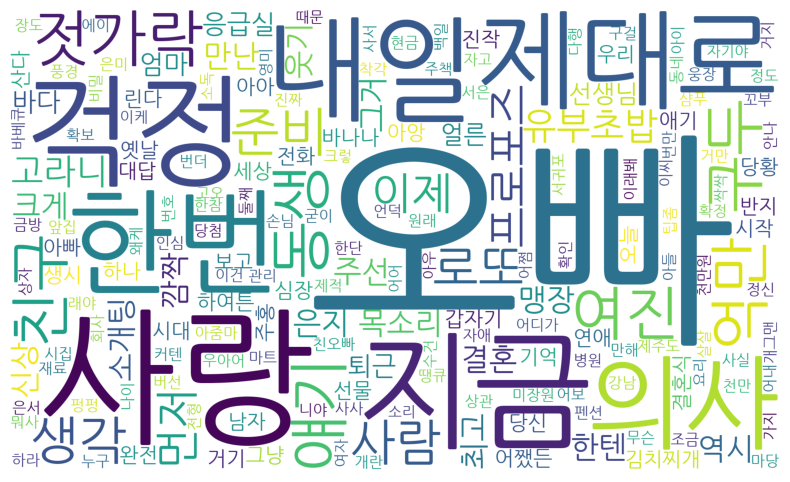

In [76]:
# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# 폰트 설정
plt.rc('font', family='NanumGothic')

# 워드클라우드 그리기
wc = WordCloud(width=2000, height=1200, background_color='white', font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
wc.generate_from_frequencies(noun_frequency)
plt.figure(figsize=(10, 6))
plt.imshow(wc)
plt.axis('off')
plt.show()